In [1]:
import os
import torch
import time
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.cuda import amp
from scipy.io import savemat
import torch.nn.functional as F
import tonic.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

# Now import from models
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.ReActNet_A_Qaw import *
from models.utils import *

#os.environ["CUDA_VISIBLE_DEVICES"] = '1,2,3,4'

/home/lab/plongour/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Begin_epoch = 0
Max_epoch = 256
Learning_rate = 1e-3
Weight_decay = 5e-6
Momentum = 0.9
Top_k = 5
AMP = False
REPRESENTATION_CHOICE = "_2_Channel_count"
#REPRESENTATION_CHOICE = "_4_Channel_" 

Dataset_path = '../data/N-imagenet_preprocessed'+REPRESENTATION_CHOICE+'/'
train_path = os.path.join(Dataset_path, 'train')
test_path = os.path.join(Dataset_path, 'test')
Batch_size = 64
Workers = 8
Targetnum = 100

Test_every_iteration = None
Name_suffix = '_step1'
Savemodel_path = './savemodels/'
Record_path = './recorddata/'
if not os.path.exists(Savemodel_path):
    os.mkdir(Savemodel_path)
if not os.path.exists(Record_path):
    os.mkdir(Record_path)

In [3]:
_seed_ = 2023
torch.manual_seed(_seed_)
np.random.seed(_seed_)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
# Création des répertoires nécessaires
os.makedirs(Savemodel_path, exist_ok=True)
os.makedirs(Record_path, exist_ok=True)
os.makedirs(Dataset_path, exist_ok=True)

if REPRESENTATION_CHOICE == "_2_Channel_count":
    def from_events_to_img(events):
        """
        Convert the event stream to a 2D image using vectorized NumPy operations.
        Works with structured arrays with named fields (x, y, t, p).
        """
        # Create an empty image
        img = np.zeros((2, 448, 448), dtype=np.float32)
        
        # Filter valid events based on coordinates
        valid_mask = ((events['x'] >= 96) & 
                    (events['x'] < 544) & 
                    (events['y'] >= 16) & 
                    (events['y'] < 464))
        
        valid_events = events[valid_mask]
        
        # Extract components
        x = valid_events['x'] - 96
        y = valid_events['y'] - 16
        p = valid_events['p']
        
        # Separate positive and negative polarities
        pos_mask = p > 0
        neg_mask = ~pos_mask
        
        # Update image at respective coordinates
        np.add.at(img[0], (y[pos_mask], x[pos_mask]), 1.0)
        np.add.at(img[1], (y[neg_mask], x[neg_mask]), 1.0)
        
        # Normalize each channel efficiently
        img /= np.maximum(np.max(np.abs(img), axis=(1, 2)), 1e-3)[:, np.newaxis, np.newaxis]
        
        return img
elif REPRESENTATION_CHOICE == "_4_Channel_":
    def from_events_to_img(events):
        """
        Convert the event stream to a 4-channel 2D image using vectorized NumPy operations.
        Works with structured arrays with named fields (x, y, t, p).
        """
        import numpy as np
        
        # Image dimensions
        H, W = 448, 448
        
        # Create an empty image (4 channels: pos_count, pos_time, neg_count, neg_time)
        img = np.zeros((4, H, W), dtype=np.float32)
        
        # Filter valid events based on coordinates
        valid_mask = ((events['x'] >= 96) &
                    (events['x'] < 544) &
                    (events['y'] >= 16) &
                    (events['y'] < 464))
        valid_events = events[valid_mask]
        
        # Extract components and adjust coordinates
        x = valid_events['x'] - 96
        y = valid_events['y'] - 16
        p = valid_events['p']
        t = valid_events['t']
        
        # Get time normalization values
        start_time = t[0] if len(t) > 0 else 0
        time_length = t[-1] - start_time if len(t) > 0 and t[-1] > start_time else 1.0
        
        # Separate positive and negative polarities
        pos_mask = p > 0
        neg_mask = ~pos_mask
        
        # Handle positive events
        pos_y, pos_x = y[pos_mask], x[pos_mask]
        pos_t = (t[pos_mask] - start_time) / time_length  # Normalize timestamps
        
        # Handle negative events
        neg_y, neg_x = y[neg_mask], x[neg_mask]
        neg_t = (t[neg_mask] - start_time) / time_length  # Normalize timestamps
        
        # Count events (channel 0 and 2)
        np.add.at(img[0], (pos_y, pos_x), 1.0)  # Positive count
        np.add.at(img[2], (neg_y, neg_x), 1.0)  # Negative count
        
        # Normalize counts
        pos_max = np.max(img[0])
        neg_max = np.max(img[2])
        img[0] /= max(pos_max, 1e-3)
        img[2] /= max(neg_max, 1e-3)
        
        # Create temporary arrays for max timestamp calculation
        pos_time_img = np.zeros((H, W), dtype=np.float32)
        neg_time_img = np.zeros((H, W), dtype=np.float32)
        
        # This mimics scatter_max by using a loop (vectorizing this is challenging in NumPy)
        for i in range(len(pos_y)):
            py, px = pos_y[i], pos_x[i]
            pos_time_img[py, px] = max(pos_time_img[py, px], pos_t[i])
        
        for i in range(len(neg_y)):
            ny, nx = neg_y[i], neg_x[i]
            neg_time_img[ny, nx] = max(neg_time_img[ny, nx], neg_t[i])
        
        # Assign timestamps to channels 1 and 3
        img[1] = pos_time_img
        img[3] = neg_time_img
        
        return img

def process_dataset(input_base_dir, output_base_dir):
    """
    Process both train and test datasets
    """
    # Traiter le jeu d'entraînement
    input_train_dir = os.path.join(input_base_dir, "train")
    output_train_dir = os.path.join(output_base_dir, "train")
    process_all_files(input_train_dir, output_train_dir)
    
    # Traiter le jeu de test
    input_test_dir = os.path.join(input_base_dir, "test")
    output_test_dir = os.path.join(output_base_dir, "test")
    process_all_files(input_test_dir, output_test_dir)

def process_all_files(input_dir, output_dir):
    """
    Process all .npz files in the input directory structure and save results
    in the same structure in the output directory.
    """
    # Créer le répertoire de sortie s'il n'existe pas
    Path(output_dir).mkdir(exist_ok=True, parents=True)
    
    # Parcourir tous les sous-dossiers (classes)
    class_dirs = [d for d in Path(input_dir).iterdir() if d.is_dir()]
    print(f"Traitement de {len(class_dirs)} classes...")
    
    for class_dir in class_dirs:
        class_name = class_dir.name
        output_class_dir = Path(output_dir) / class_name
        output_class_dir.mkdir(exist_ok=True, parents=True)
        
        print(f"Traitement de la classe: {class_name}")
        
        # Parcourir tous les fichiers .npz dans cette classe
        npz_files = list(class_dir.glob("*.npz"))
        
        for npz_file in tqdm(npz_files, desc=f"Classe {class_name}"):
            try:
                # Charger le fichier .npz
                data = np.load(str(npz_file))
                
                # Détecter le nom de la clé d'événements
                event_key = 'event_data'
                event_stream = data[event_key]
                
                img = from_events_to_img(event_stream)
                
                # Créer le fichier de sortie avec le même nom
                output_file = output_class_dir / npz_file.name
                
                # Sauvegarder l'image transformée
                np.savez_compressed(
                    str(output_file),
                    image=img,
                    label=class_name,
                    allow_pickle=True,
                )
            except Exception as e:
                print(f"Erreur lors du traitement de {npz_file}: {e}")
    
    print(f"Traitement terminé pour {input_dir} -> {output_dir}")

# DataLoader qui pourrait être utilisé ultérieurement
class NImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        
        # Trouver toutes les classes et fichiers
        self.samples = []
        self.class_to_idx = {}
        
        for idx, class_dir in enumerate(sorted(Path(data_path).iterdir())):
            if not class_dir.is_dir():
                continue
                
            class_name = class_dir.name
            self.class_to_idx[class_name] = idx
            
            for npz_file in class_dir.glob("*.npz"):
                self.samples.append((str(npz_file), idx))
        
        print(f"Chargé {len(self.samples)} échantillons de {len(self.class_to_idx)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        data = np.load(file_path)
        image = data['image']
        
        return image, label

if os.path.exists(train_path) and os.path.exists(test_path):
    print("Les données prétraitées existent déjà.")
else:
    print("Prétraitement des données...")
    input_dir = "N-imagenet/"
    process_dataset(input_dir, Dataset_path)
        
    # Exemple d'utilisation du dataset (décommentez pour tester)
train_dataset = NImageNetDataset(train_path)
test_dataset = NImageNetDataset(test_path)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=Batch_size, shuffle=True, num_workers=Workers, pin_memory=True#, drop_last=True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=Batch_size, shuffle=False, num_workers=Workers, pin_memory=True#, drop_last=False
)

Les données prétraitées existent déjà.
Chargé 129395 échantillons de 100 classes
Chargé 5000 échantillons de 100 classes


In [10]:
"""transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0)),
    Lighting(0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([                      
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

Train_data = datasets.ImageFolder(root=Dataset_path+'train', transform=transform_train)
Test_data = datasets.ImageFolder(root=Dataset_path+'val', transform=transform_test)

train_data_loader = torch.utils.data.DataLoader(
    dataset=Train_data,
    batch_size=Batch_size,
    shuffle=True,
    num_workers=Workers, 
    pin_memory=True,
    drop_last=True
)

test_data_loader = torch.utils.data.DataLoader(
    dataset=Test_data,
    batch_size=Batch_size,
    shuffle=False,
    num_workers=Workers, 
    pin_memory=True,
    drop_last=False
)"""

"transform_train = transforms.Compose([\n    transforms.RandomResizedCrop(224, scale=(0.08, 1.0)),\n    Lighting(0.1),\n    transforms.RandomHorizontalFlip(),\n    transforms.ToTensor(),\n    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))\n])\n\ntransform_test = transforms.Compose([                      \n    transforms.Resize(256),\n    transforms.CenterCrop(224),\n    transforms.ToTensor(),\n    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))\n])\n\nTrain_data = datasets.ImageFolder(root=Dataset_path+'train', transform=transform_train)\nTest_data = datasets.ImageFolder(root=Dataset_path+'val', transform=transform_test)\n\ntrain_data_loader = torch.utils.data.DataLoader(\n    dataset=Train_data,\n    batch_size=Batch_size,\n    shuffle=True,\n    num_workers=Workers, \n    pin_memory=True,\n    drop_last=True\n)\n\ntest_data_loader = torch.utils.data.DataLoader(\n    dataset=Test_data,\n    batch_size=Batch_size,\n    shuffle=False,\n    num_worker

In [11]:
"""model_teacher = torchvision.models.__dict__['resnet34'](weights = torchvision.models.ResNet34_Weights.IMAGENET1K_V1)
model_teacher = nn.DataParallel(model_teacher).cuda()
for p in model_teacher.parameters():
    p.requires_grad = False
model_teacher.eval()"""

"model_teacher = torchvision.models.__dict__['resnet34'](weights = torchvision.models.ResNet34_Weights.IMAGENET1K_V1)\nmodel_teacher = nn.DataParallel(model_teacher).cuda()\nfor p in model_teacher.parameters():\n    p.requires_grad = False\nmodel_teacher.eval()"

In [26]:
img, label = next(iter(train_data_loader))

In [28]:
label

tensor([11, 49, 73, 78, 53, 74, 70,  0, 16,  6,  1, 46, 84, 87, 45, 45, 81, 98,
        38, 77, 43, 70, 23, 61, 23, 94, 83, 84, 49,  4,  2, 36, 38, 56, 19, 91,
        64, 68,  5, 43, 63, 11, 26, 51, 75, 62, 81, 18, 21,  3, 54,  5, 10,  5,
        94, 94, 61, 32, 37, 83, 83, 33, 87, 25])

In [6]:
img.size()

torch.Size([64, 2, 448, 448])

In [29]:
image = img[60][0].numpy()
print("image shape:", image.shape)
print("minimum value:", np.min(image))
print("maximum value:", np.max(image))
print("mean value:", np.mean(image))

image shape: (448, 448)
minimum value: 0.0
maximum value: 1.0
mean value: 0.010924324


In [30]:
image2 = img[61][0].numpy()
print("image shape:", image.shape)
print("minimum value:", np.min(image))
print("maximum value:", np.max(image))
print("mean value:", np.mean(image))

image shape: (448, 448)
minimum value: 0.0
maximum value: 1.0
mean value: 0.010924324


In [31]:
import matplotlib.pyplot as plt

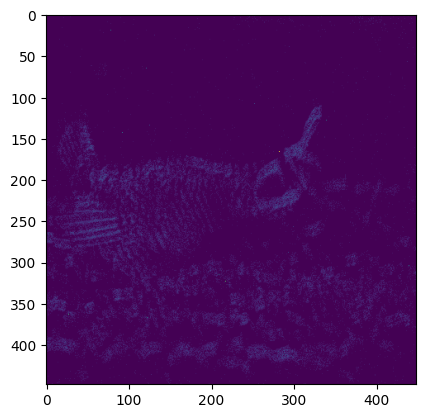

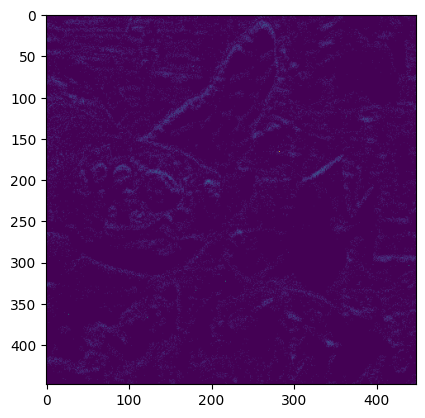

In [32]:
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()

In [ ]:
#net = ResNet18(num_classes=Targetnum, imagenet=True)
net = Reactnet(num_classes=Targetnum, imagenet=True)
net.feature[0] = firstconv3x3(2, stage_out_channel[0], 2)

In [12]:
net = nn.DataParallel(net).cuda()
max_test_acc = 0.
if Begin_epoch!=0:
    net.load_state_dict(torch.load(Savemodel_path + f'epoch{Begin_epoch-1}{Name_suffix}.h5'))
    max_test_acc = np.load(Savemodel_path + f'max_acc{Name_suffix}.npy')
    max_test_acc = max_test_acc.item()

scaler = amp.GradScaler() if AMP else None
Test_top1 = []
Test_topk = []
Test_lossall = []
Epoch_list = []
Iteration_list = []

In [13]:
all_parameters = net.parameters()
weight_parameters = []
for pname, p in net.named_parameters():
    if (p.ndimension() == 4 or 'conv' in pname) and 'L_alpha' not in pname:
        weight_parameters.append(p)
weight_parameters_id = list(map(id, weight_parameters))
other_parameters = list(filter(lambda p: id(p) not in weight_parameters_id, all_parameters))

#criterion_train = DistributionLoss()
criterion_test = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params' : other_parameters, 'weight_decay' : 0., 'initial_lr': Learning_rate},
    {'params' : weight_parameters, 'weight_decay' : Weight_decay, 'initial_lr': Learning_rate}],
    lr = Learning_rate)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step : (1.0-step/Max_epoch), last_epoch=Begin_epoch-1)

In [14]:
def test_model(net, max_test_acc, data_loader=test_data_loader, criterion=criterion_test, epoch=None, iteration=None, record=True):
    net.eval()
    test_samples = 0
    test_loss = 0
    test_acc_top1 = 0
    test_acc_topk = 0
    
    with torch.no_grad():
        for img, label in tqdm(data_loader):
            img = img.cuda()
            label = label.cuda()
            label_onehot = F.one_hot(label, Targetnum).float()
            
            out_fr = net(img)
            loss = criterion(out_fr, label)
                
            test_samples += label.numel()
            test_loss += loss.item() * label.numel()

            test_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
            _, pred = out_fr.topk(Top_k, 1, True, True)
            test_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
    
    test_loss /= test_samples
    test_acc_top1 /= test_samples
    test_acc_topk /= test_samples

    if test_acc_top1 >= max_test_acc:
        max_test_acc = test_acc_top1
        torch.save(net.state_dict(), Savemodel_path + f'max_acc{Name_suffix}.h5')
        np.save(Savemodel_path + f'max_acc{Name_suffix}.npy', np.array(max_test_acc))

    if record:
        assert epoch is not None, "epoch is None!"
        assert iteration is not None, "iteration is None!"
        
        Epoch_list.append(epoch+1)
        Iteration_list.append(iteration+1)
        Test_top1.append(test_acc_top1)
        Test_topk.append(test_acc_topk)
        Test_lossall.append(test_loss)

        record_data = np.array([Epoch_list, Iteration_list, Test_top1, Test_topk, Test_lossall]).T
        mdic = {f'Record_data':record_data, f'Record_meaning':['Epoch_list', 'Iteration_list', 'Test_top1', f'Test_top{Top_k}', 'Test_loss']}

        savemat(Record_path + f'Test_{Begin_epoch}_{epoch}{Name_suffix}.mat',mdic)
        if os.path.exists(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat'):
            os.remove(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat')

    return test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [15]:
def train_model(net, max_test_acc, epoch, data_loader=train_data_loader, optimizer=optimizer, criterion=criterion_test, scaler=scaler, record=True):
    train_samples = 0
    train_loss = 0
    train_acc_top1 = 0
    train_acc_topk = 0
    
    for i, (img, label) in enumerate(tqdm(data_loader)):
        net.train()
        img = img.cuda()
        label = label.cuda()
        label_onehot = F.one_hot(label, Targetnum).float()
        
        if AMP:
            with amp.autocast():
                out_fr = net(img)
                out_teacher = model_teacher(img)
                loss = criterion(out_fr, out_teacher)
        else:
            out_fr = net(img)
            out_teacher = label#model_teacher(img)
            loss = criterion(out_fr, out_teacher)
            
        train_samples += label.numel()
        train_loss += loss.item() * label.numel()

        train_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
        _, pred = out_fr.topk(Top_k, 1, True, True)
        train_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
        
        optimizer.zero_grad()
        if AMP:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()

            parameters_list = []
            for name, p in net.named_parameters():
                if not 'fc' in name:
                    parameters_list.append(p)
            adaptive_clip_grad(parameters_list, clip_factor=0.02)
            
            optimizer.step()

        if Test_every_iteration is not None:
            if (i+1) % Test_every_iteration == 0:
                test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
                print(f'Test_loss: {test_loss:.4f}, Test_acc_top1: {test_acc_top1:.4f}, Test_acc_top{Top_k}: {test_acc_topk:.4f}, Max_test_acc: {max_test_acc:.4f}')
    
    train_loss /= train_samples
    train_acc_top1 /= train_samples
    train_acc_topk /= train_samples

    test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
        
    return train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [1]:
for epoch in range(Begin_epoch, Max_epoch):

    start_time = time.time()
    train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc = train_model(net, max_test_acc, epoch)
    
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        
    lr_scheduler.step()

    print(f'''epoch={epoch}, train_acc_top1={train_acc_top1:.4f}, train_acc_top{Top_k}={train_acc_topk:.4f}, train_loss={train_loss:.4f}, test_top1={test_acc_top1:.4f}, test_top{Top_k}={test_acc_topk:.4f}, test_loss={test_loss:.4f}, max_test_acc={max_test_acc:.4f}, total_time={(time.time() - start_time):.4f}, LR={lr:.8f}''')
    
    torch.save(net.state_dict(), Savemodel_path + f'epoch{epoch}{Name_suffix}.h5')
    if os.path.exists(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5'):
        os.remove(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5')

NameError: name 'Begin_epoch' is not defined

In [16]:
net.load_state_dict(torch.load(Savemodel_path + f'max_acc{Name_suffix}.h5'))

<All keys matched successfully>

In [17]:
Confusion_Matrix = torch.zeros((Targetnum, Targetnum))
net.eval()
with torch.no_grad():
    for img, label in tqdm(test_data_loader):
        img = img.cuda()
        label = label.cuda()
        out_fr = net(img)
        guess = out_fr.argmax(1)
        for j in range(len(label)):
            Confusion_Matrix[label[j],guess[j]] += 1
acc = Confusion_Matrix.diag()
acc = acc.sum()/Confusion_Matrix.sum()
print(f'Confusion_Matrix = {Confusion_Matrix}')
print(f'acc = {acc}')

  0%|          | 0/79 [00:00<?, ?it/s]libibverbs: Warning: couldn't load driver 'libmlx4-rdmav34.so': libmlx4-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'librxe-rdmav34.so': librxe-rdmav34.so: cannot open shared object file: No such file or directory
100%|██████████| 79/79 [00:23<00:00,  3.39it/s]

Confusion_Matrix = tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
acc = 0.009999999776482582


In [25]:
summary(net, (2, 448, 448))

Layer (type:depth-idx)                                  Output Shape              Param #
├─Reactnet: 1-1                                         []                        --
├─Reactnet: 1                                           []                        --
|    └─ModuleList: 2                                    []                        --
|    |    └─firstconv3x3: 3-1                           []                        608
├─Reactnet: 1-2                                         [-1, 100]                 --
├─Reactnet: 1                                           []                        --
|    └─ModuleList: 2                                    []                        --
|    |    └─firstconv3x3: 3-2                           [-1, 32, 448, 448]        --
|    |    └─BasicBlock: 3-3                             []                        11,712
|    |    └─BasicBlock: 3-4                             [-1, 64, 224, 224]        --
|    |    └─BasicBlock: 3-5                            

Layer (type:depth-idx)                                  Output Shape              Param #
├─Reactnet: 1-1                                         []                        --
├─Reactnet: 1                                           []                        --
|    └─ModuleList: 2                                    []                        --
|    |    └─firstconv3x3: 3-1                           []                        608
├─Reactnet: 1-2                                         [-1, 100]                 --
├─Reactnet: 1                                           []                        --
|    └─ModuleList: 2                                    []                        --
|    |    └─firstconv3x3: 3-2                           [-1, 32, 448, 448]        --
|    |    └─BasicBlock: 3-3                             []                        11,712
|    |    └─BasicBlock: 3-4                             [-1, 64, 224, 224]        --
|    |    └─BasicBlock: 3-5                            

In [20]:
from torchsummary import summary

In [24]:
net(img)

tensor([[-0.1326, -0.1823, -0.0751, -0.2864, -0.0758, -0.1022, -0.0435, -0.1204,
         -0.1024, -0.1462, -0.1661, -0.0572, -0.1153, -0.1629, -0.0864, -0.0393,
         -0.0677, -0.0533, -0.0704, -0.0258, -0.1670, -0.1695, -0.1951, -0.2549,
         -0.1142, -0.1087,  0.0458, -0.1034, -0.1508, -0.1417, -0.0047, -0.2046,
         -0.0418, -0.1411, -0.1585, -0.0731, -0.1531, -0.0371, -0.1474, -0.0247,
         -0.1453, -0.0428, -0.0620, -0.2476, -0.1576, -0.1950, -0.1067, -0.1186,
         -0.1486, -0.1122, -0.1014, -0.1564, -0.2392, -0.0505,  0.0311, -0.1412,
         -0.0494, -0.2036, -0.1932, -0.0729, -0.0246, -0.1491, -0.2430, -0.0858,
         -0.0747, -0.0511, -0.0783, -0.0887,  0.0211, -0.1680, -0.1364, -0.1883,
         -0.0881, -0.1392, -0.1419, -0.1159, -0.1236, -0.1041, -0.0253, -0.1488,
         -0.0501, -0.0326, -0.0488, -0.1919, -0.0456, -0.1744, -0.0163, -0.2664,
         -0.2060, -0.1094, -0.1248, -0.1370, -0.0313, -0.1031, -0.0141, -0.0022,
         -0.1549, -0.1629, -